<a href="https://colab.research.google.com/github/dcepeda2/Cumulos-abiertos/blob/main/Informe_Ganancia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from glob import glob
from astropy.io import fits
from google.colab import drive
import numpy as np
import itertools
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import pandas as pd
from scipy.stats import linregress
from scipy.stats import median_abs_deviation
from astropy.stats import biweight_location, biweight_scale

In [ ]:
np.set_printoptions(linewidth=100)
plt.rcParams["image.cmap"] = "gray"
plt.rcParams["image.origin"] = "lower"

def quantile_imshow(img,lower=0.01,upper=0.99,**kwargs):
    img_vmin = np.quantile(img,lower)
    img_vmax = np.quantile(img,upper)
    return plt.imshow(img,vmin=img_vmin,vmax=img_vmax,**kwargs)

In [ ]:
files = glob("Data/uniandes/*.fit")
IMG = []
for file in files:
  IMG.append(fits.getdata(file))
IMG = np.array(IMG)

In [ ]:
T = {'Objeto':[],'Tipo':[],'Mediana':[],'Media':[]}
for file in files:
  T['Objeto'].append(fits.getheader(file)['OBJECT'])
  T['Tipo'].append(fits.getheader(file)['IMAGETYP'])

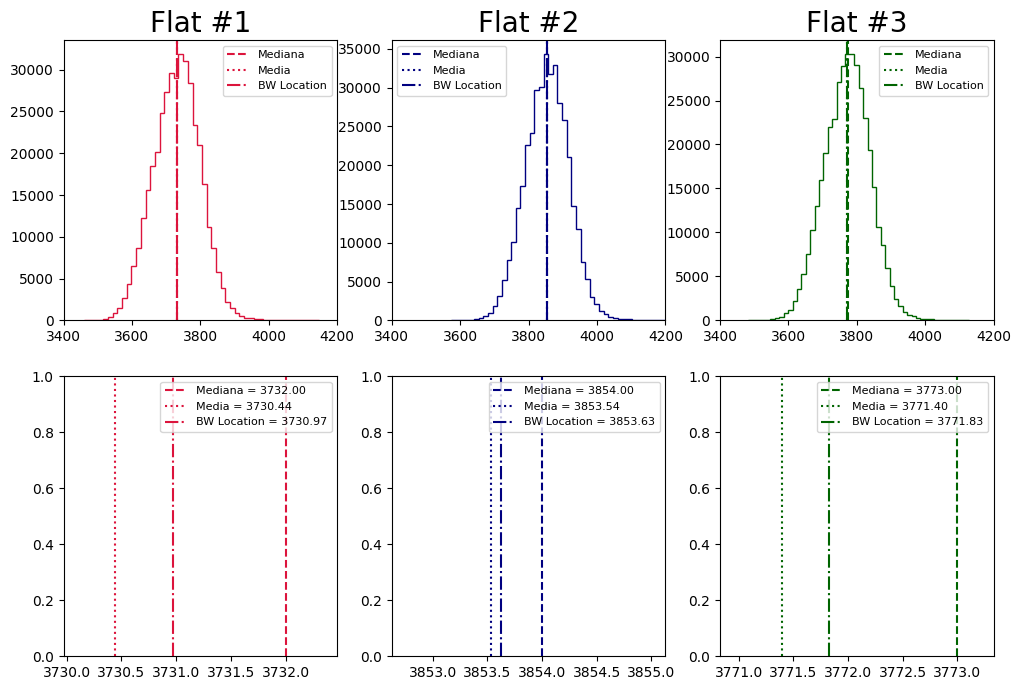

In [ ]:
G = [[],[],[]]
clr = ['crimson','navy','darkgreen']
j = 0
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(12,8))
for i in range(len(T['Objeto'])):
  if T['Objeto'][i] == 'DOME FLAT':
    datos_histograma = IMG[i].ravel()
    Gmedian = np.median(datos_histograma)/median_abs_deviation(datos_histograma,scale="normal")**2
    Gmean = np.mean(datos_histograma)/np.std(datos_histograma)**2
    Gbw = biweight_location(datos_histograma)/biweight_scale(datos_histograma)**2
    G[0].append(Gmedian)
    G[1].append(Gmean)
    G[2].append(Gbw)
    plt.sca(ax[0,j])
    plt.hist(datos_histograma, bins=50, histtype='step',color=clr[j])
    str_ = "Flat #"+str(j+1)
    plt.title(str_, fontsize=20)
    plt.axvline(np.median(datos_histograma), c=clr[j],linestyle="--",label="Mediana")
    plt.axvline(np.mean(datos_histograma), c=clr[j],linestyle=":",label="Media")
    plt.axvline(biweight_location(datos_histograma), c=clr[j],linestyle="-.",label="BW Location")
    plt.legend(fontsize = 8)
    plt.xlim(3400,4200)
    plt.sca(ax[1,j])
    plt.axvline(np.median(datos_histograma), c=clr[j],linestyle="--",label = r'Mediana = {:.2f}'.format(np.median(datos_histograma)))
    plt.axvline(np.mean(datos_histograma), c=clr[j],linestyle=":",label=r'Media = {:.2f}'.format(np.mean(datos_histograma)))
    plt.axvline(biweight_location(datos_histograma), c=clr[j],linestyle="-.",label=r'BW Location = {:.2f}'.format(biweight_location(datos_histograma)))
    plt.legend(fontsize = 8)
    plt.xlim(biweight_location(datos_histograma)-1,biweight_location(datos_histograma)+1.5)
    j+=1

In [ ]:
indices_dome_flat = np.where((np.array(T['Objeto']) == 'DOME FLAT'))[0]
indices_dome_bias = np.where((np.array(T['Objeto']) == 'BIAS'))[0]
flats = IMG[indices_dome_flat]
bias = IMG[indices_dome_bias]

In [ ]:
ganancias = []

combinaciones_flats = itertools.combinations(flats, 2)

for f1, f2 in combinaciones_flats:
    mean_f = biweight_location(f1) + biweight_location(f2)
    diff_f = f1.astype('float64') - f2.astype('float64')
    std_f = biweight_scale(diff_f) ** 2

    combinaciones_bias = itertools.combinations(bias, 2)
    for b1, b2 in combinaciones_bias:
        mean_b = biweight_location(b1) + biweight_location(b2)
        diff_b = b1.astype('float64') - b2.astype('float64')
        std_b = biweight_scale(diff_b) ** 2

        ganancia = (mean_f - mean_b) / (std_f - std_b)
        ganancias.append(ganancia)

len(ganancias)
biweight_location(ganancias)

1.3970473073508867

In [41]:
def visualizar_imagen(img, factor_escala, **kwargs):
    desviacion = biweight_scale(img.flatten())
    centro = biweight_location(img.flatten())
    vmin = centro - factor_escala * desviacion
    vmax = centro + factor_escala * desviacion
    imagen_mostrada = plt.imshow(img, vmin=vmin, vmax=vmax, cmap='CMRmap', **kwargs)
    return imagen_mostrada, centro, desviacion, vmax

archivos_bias = glob("Data/BIAS/*.fit")
imagenes_bias = np.array([fits.getdata(archivo) for archivo in archivos_bias])

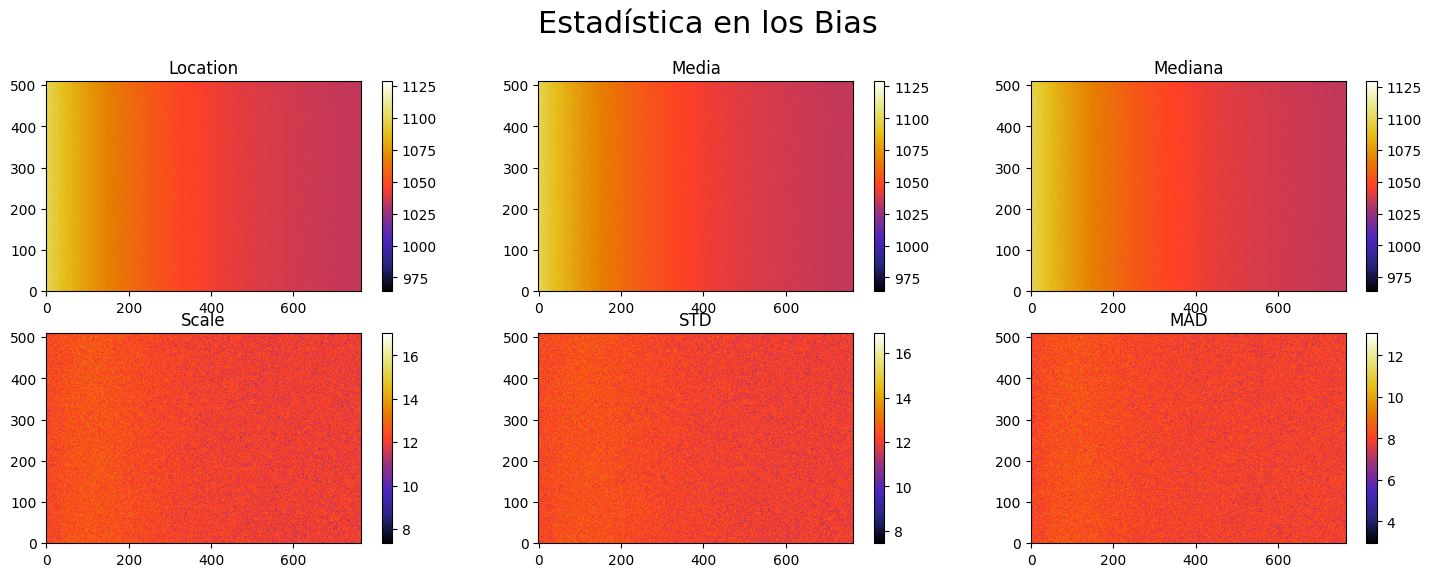

In [42]:
n=5
bias_location = biweight_location(imagenes_bias, axis=0)
bias_media = np.mean(imagenes_bias, axis=0)
bias_mediana = np.median(imagenes_bias, axis=0)
bias_escala = biweight_scale(imagenes_bias, axis=0)
bias_std = np.std(imagenes_bias, axis=0)
bias_mad = median_abs_deviation(imagenes_bias, axis=0)
fig, ax = plt.subplots(ncols = 3,nrows=2,figsize=(18,6))
plt.suptitle("Estadística en los Bias", y=1, fontsize = 22)
plt.sca(ax[0,0])
visualizar_imagen(bias_location,n)[0]
plt.title("Location")
plt.colorbar()
plt.sca(ax[0,1])
visualizar_imagen(bias_media,n)[0]
plt.title("Media")
plt.colorbar()
plt.sca(ax[0,2])
visualizar_imagen(bias_mediana,n)[0]
plt.title("Mediana")
plt.colorbar()
plt.sca(ax[1,0])
visualizar_imagen(bias_escala,n)[0]
plt.title("Scale")
plt.colorbar()
plt.sca(ax[1,1])
visualizar_imagen(bias_std,n)[0]
plt.title("STD")
plt.colorbar()
plt.sca(ax[1,2])
visualizar_imagen(bias_mad,n)[0]
plt.title("MAD")
plt.colorbar()

In [22]:
IMGF = []
for time in ['0.04','0.06','0.09','0.11','0.13','0.16','0.18','0.20','0.23','0.25']:
  flats_propios = glob(f'Data/FLATS/{time}/*.fit')
  time_IMGF = []
  for file in flats_propios:
    time_IMGF.append(fits.getdata(file))
  IMGF.append(time_IMGF)

In [36]:
FLAT_mdn = np.median(IMGF,axis=1)
FLAT_mdn_no_BIAS = FLAT_mdn - bias_mediana
median_FLAT = np.array([])
variance_FLAT = np.array([])
for i in FLAT_mdn_no_BIAS:
  median_FLAT = np.append(median_FLAT,np.median(i))
  variance_FLAT = np.append(variance_FLAT,np.var(i))

slope, intercept, r, p, se = linregress(median_FLAT,variance_FLAT)
lin = median_FLAT*slope + intercept

246.79454419957656

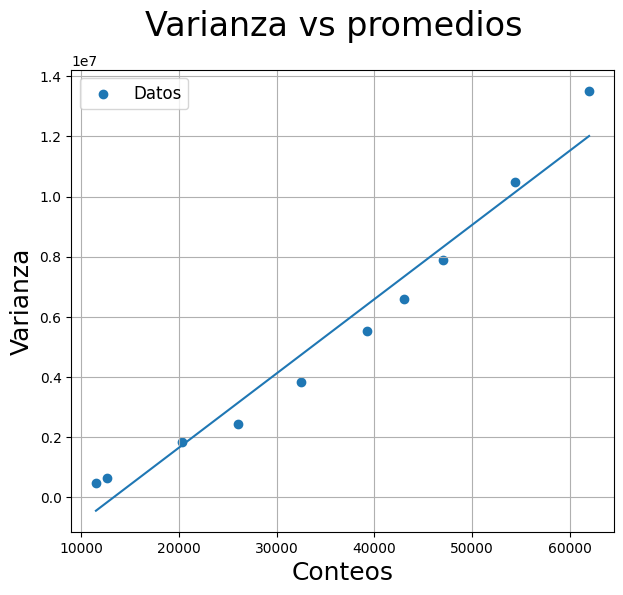

In [44]:
fig = plt.figure(figsize=(7,6))
plt.suptitle("Varianza vs promedios",fontsize = 24,y=0.98)
plt.plot(median_FLAT,lin)
plt.xlabel("Conteos",fontsize = 18)
plt.ylabel("Varianza",fontsize = 18)
plt.scatter(median_FLAT,variance_FLAT,label='Datos')
plt.legend(fontsize=12,loc='upper left')
plt.grid(True)
slope

In [26]:
Gain = 1./slope
Gain

0.0041879044141600015